This notebook is used to produce the visualizations in figure 2 and accompanying supplementary materials.

In [14]:
#setup and imports, functions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import os

#for fitting distribution and computing sigma/skew
import pandas as pd
import seaborn as sns
from scipy import stats

def coupon_collector(n_mutations, n_targets):
    return 1 - ((1 - 1 / n_targets) ** n_mutations)

#set paths
pwd = os.getcwd() #this is the current directory
base_dir =  pwd
data_dir = os.path.join(pwd,'biobloomrxiv_source_data/') #suggested data directory, data available at figshare 10.6084/m9.figshare.31053121
fig_dir = os.path.join(base_dir, 'figures')




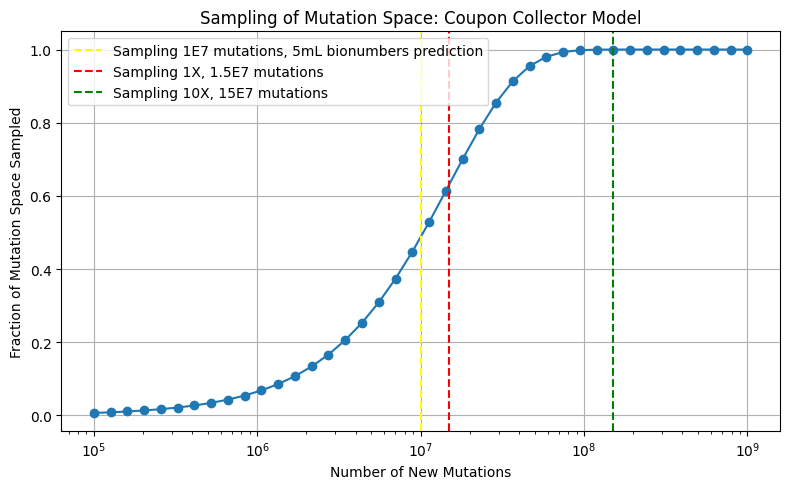

In [15]:
#this block estimates the the fraction of saturation mutation space sampled, here first by number of mutations
#this is an illustrative exercise, more complexity is added in further blocks

# Parameters
genome_sites = int(15e6)  # total possible mutation sites
mutation_trials = np.logspace(5, 9, 40, dtype=int)  # number of new mutations tried, from 1e5 to 1e8



# Calculate expected fraction of genome covered
fractions = [coupon_collector(n, genome_sites) for n in mutation_trials]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(mutation_trials, fractions, marker='o')
plt.axvline(1e7, color='yellow', linestyle='--', label='Sampling 1E7 mutations, 5mL bionumbers prediction')
plt.axvline(1.5e7, color='red', linestyle='--', label='Sampling 1X, 1.5E7 mutations')
plt.axvline(15e7, color='green', linestyle='--', label='Sampling 10X, 15E7 mutations')
plt.xlabel('Number of New Mutations')
plt.ylabel('Fraction of Mutation Space Sampled')
plt.xscale('log')
plt.title('Sampling of Mutation Space: Coupon Collector Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

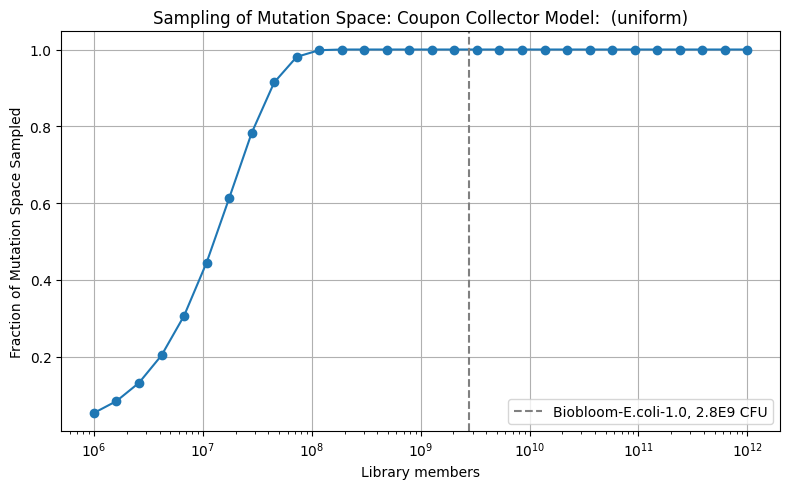

In [5]:
#modeling mutations for biobloom library cloning

# Parameters
genome_size = int(4.6e6) 
genome_sites = genome_size * 3  # total possible mutation sites
library_members = np.logspace(6, 12, 30, dtype=int) # number of CFU cloned
#in biobloom, each additional library member is another "draw" from the total degenerate library
mutations = library_members * 3/4  #only 3/4 of the donor library gets mutations

# Calculate expected fraction of genome covered, uniform distribution
biobloom_fractions_uniform = [coupon_collector(n, genome_sites) for n in mutations]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(library_members, biobloom_fractions_uniform, marker='o')
plt.axvline(2.8E9,  color='gray', ls='--', label='Biobloom-E.coli-1.0, 2.8E9 CFU')
plt.xlabel('Library members')
plt.ylabel('Fraction of Mutation Space Sampled')
plt.xscale('log')
plt.title('Sampling of Mutation Space: Coupon Collector Model:  (uniform)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
### functions to incorporate skew into the model, as uniform distribution is likely too conservative

def expected_fraction_coverage_weighted(
    n: int,
    M: int,
    k_classes: int = 100,
    sigma: float = 1.0,
    rng=None
) -> float:
    """
    Expected fraction of unique sites observed after n draws from M sites
    when per-site selection probs follow a log-normal distribution.
    
    Parameters:
    -----------
    n : int
        Number of draws
    M : int
        Total number of sites
    k_classes : int
        Number of rate classes (default 100)
    sigma : float
        Standard deviation of log-normal distribution
    rng : numpy random generator (optional)
    """
    rng = np.random.default_rng(rng)
    f = np.full(k_classes, 1.0 / k_classes)
    
    # Log-normal parameters: mu = -0.5 * sigma^2 so mean ~ 1
    mu = -0.5 * sigma * sigma
    r = rng.lognormal(mean=mu, sigma=sigma, size=k_classes)
    
    mean_r = np.sum(f * r)
    p = r / (M * mean_r)  # per-site probability in each class
    
    # Expected coverage fraction
    frac = np.sum(f * (1.0 - np.exp(n * np.log1p(-p))))
    return float(frac)


## wrapper to run the above multiple times and average the results
def expected_fraction_coverage_weighted_reps(
    n: int,
    M: int,
    k_classes: int = 100,
    sigma: float = 1.0,
    reps: int = 100,
    rng=None
) -> float:
    """
    Run the coverage model multiple times and average the results.
    """
    rng = np.random.default_rng(rng)
    vals = []

    for _ in range(reps):
        vals.append(
            expected_fraction_coverage_weighted(
                n=n,
                M=M,
                k_classes=k_classes,
                sigma=sigma,
                rng=rng
            )
        )

    return float(np.mean(vals))

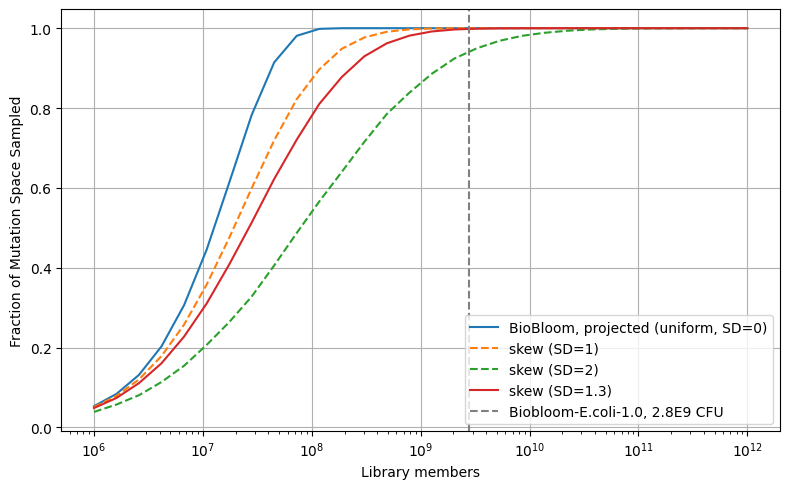

In [6]:
###incorporating skew into the biobloom model, plots

genome_size = int(4.6e6)
genome_sites = genome_size * 3
library_members = np.logspace(6, 12, 30, dtype=int)
biobloom_mutations = library_members * 3/4 #only 3/4 of the donor library gets mutations, the rest are WT

##biobloom projections
# Uniform (baseline)
uniform = [expected_fraction_coverage_weighted_reps(int(n), genome_sites, sigma=0.0, reps = 10) for n in biobloom_mutations]
# Skewed examples
mild_skew  = [expected_fraction_coverage_weighted_reps(int(n), genome_sites, sigma=1,  k_classes=1000, reps = 100) for n in biobloom_mutations]
measured_skew  = [expected_fraction_coverage_weighted_reps(int(n), genome_sites, sigma=1.3,  k_classes=1000, reps = 100) for n in biobloom_mutations]
heavy_skew = [expected_fraction_coverage_weighted_reps(int(n), genome_sites, sigma=2,  k_classes=1000, reps = 100) for n in biobloom_mutations]


plt.figure(figsize=(8,5))
plt.plot(library_members, uniform,     label='BioBloom, projected (uniform, SD=0)')
plt.plot(library_members, mild_skew,   label='skew (SD=1)', linestyle='--')
plt.plot(library_members, heavy_skew,  label='skew (SD=2)', linestyle='--')
plt.plot(library_members, measured_skew,  label='skew (SD=1.3)')
#plt.axvline(1.5e7, color='red',   ls='--', label='Sampling 1X, 1.5E7 CFU')
plt.axvline(2.8E9,  color='gray', ls='--', label='Biobloom-E.coli-1.0, 2.8E9 CFU')
plt.xscale('log'); plt.xlabel('Library members'); plt.ylabel('Fraction of Mutation Space Sampled')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

In [7]:
#predict fraction of SNPs sampled when sigma is 1.3, for text

num_cfu = 4.8E9
num_mutations = num_cfu * 3/4
expected_fraction_coverage_weighted_reps(num_mutations, genome_sites, sigma=1.3,  k_classes=1000, reps = 100)

0.9994220308866459

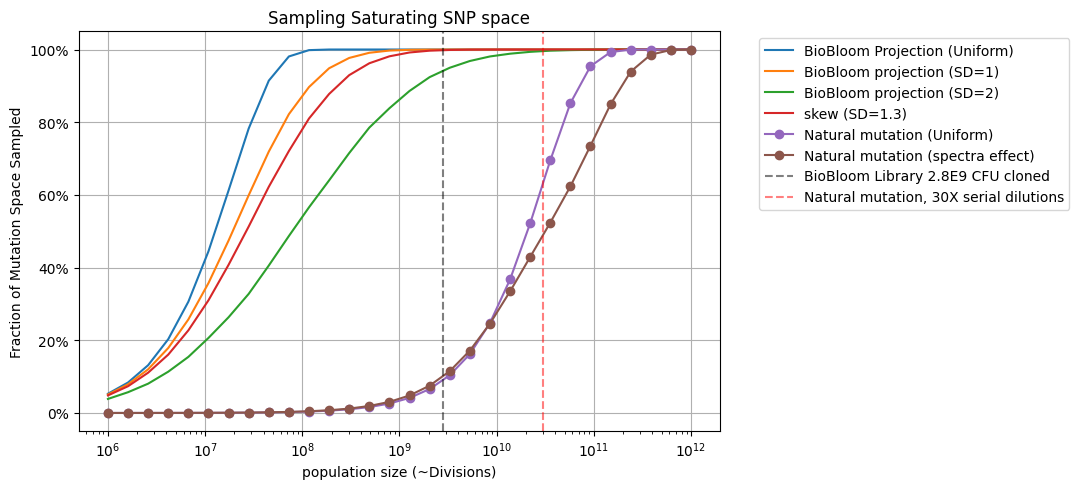

In [ ]:
### Comparing biobloom to mutations present in natural populations.


# mutation spectra parameters (genome parameters unchanged)
#genome_size = int(5e6) 
#mutation_space = genome_size * 3 # 15 million substitution events (1 per base assumed)
transition_fraction = 1/3#``
transversion_fraction = 2/3
transition_sites = int(genome_sites * transition_fraction)
transversion_sites = int(genome_sites * transversion_fraction)

# Mutation rates per base per division
overall_mutation_rate = 1E-10

transition_rate = 1e-10
transversion_rate = 2e-11
#mutagenic 
mutagenic_transition_rate = 1E-6
mutagenic_transversion_rate = .43 * 1E-6


# Number of genome replications (cell divisions)
library_members = np.logspace(6, 12, 30, dtype=int)  # number of CFU in a population, extended to 1E10
divisions = library_members # divisions can be approximated by total CFU


# Calculate number of mutations
mutations = divisions * overall_mutation_rate * genome_size
transition_mutations = divisions * transition_rate * genome_size
transversion_mutations = divisions * transversion_rate * genome_size
#for mutagenic version
mutagenic_transition_mutations = divisions * mutagenic_transition_rate * genome_size
mutagenic_transversion_mutations = divisions * mutagenic_transversion_rate * genome_size


# Calculate sampled fractions
sampled_mutations = [coupon_collector(n, genome_sites) for n in mutations]
transition_fraction_sampled = [coupon_collector(n, transition_sites) for n in transition_mutations]
transversion_fraction_sampled = [coupon_collector(n, transversion_sites) for n in transversion_mutations]
#for mutagenic version
mutagenic_transition_fraction_sampled = [coupon_collector(n, transition_sites) for n in mutagenic_transition_mutations]
mutagenic_transversion_fraction_sampled = [coupon_collector(n, transversion_sites) for n in mutagenic_transversion_mutations]

# Weighted average genome coverage
combined_fraction_sampled = [
    (transition_fraction * ti + transversion_fraction * tv)#
    for ti, tv in zip(transition_fraction_sampled, transversion_fraction_sampled)
]
#for mutagenic version
combined_mutagenic_fraction_sampled = [
    (transition_fraction * ti + transversion_fraction * tv)#
    for ti, tv in zip(mutagenic_transition_fraction_sampled, mutagenic_transversion_fraction_sampled)
]

# Plotting
plt.figure(figsize=(11, 5))
plt.plot(library_members, uniform,     label='BioBloom Projection (Uniform)')
plt.plot(library_members, mild_skew,   label='BioBloom projection (SD=1)')
plt.plot(library_members, heavy_skew,  label='BioBloom projection (SD=2)')
plt.plot(library_members, measured_skew,  label='skew (SD=1.3)')
plt.plot(library_members, sampled_mutations, label='Natural mutation (Uniform)', marker='o')
plt.plot(library_members, combined_fraction_sampled, label='Natural mutation (spectra effect)', marker='o')
#plt.plot(library_members, combined_mutagenic_fraction_sampled, label='Mutagenic plasmid ALE, mutation spectra effect', marker='o')
#plt.plot(library_members, biobloom_fractions, label= 'BioBloom projection', marker='o')

#plt.axvline(1.5e7, color='black', linestyle='-', label='Sampling BioBloom 1X, 1.5E7 CFU', alpha=0.5)
plt.axvline(2.8E9, color='black', linestyle='--', label='BioBloom Library 2.8E9 CFU cloned', alpha=0.5)
#plt.axvline(1e9, color='blue', linestyle='--', label='Natural mutation, ~0.5mL culture sampled (1E9 CFU)', alpha=0.5)
plt.axvline(1e9*30, color='red', linestyle='--', label='Natural mutation, 30X serial dilutions', alpha=0.5)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}')) #y axis as percents
plt.xscale('log')
plt.xlabel('population size (~Divisions)')
plt.ylabel('Fraction of Mutation Space Sampled')
plt.title('Sampling Saturating SNP space')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

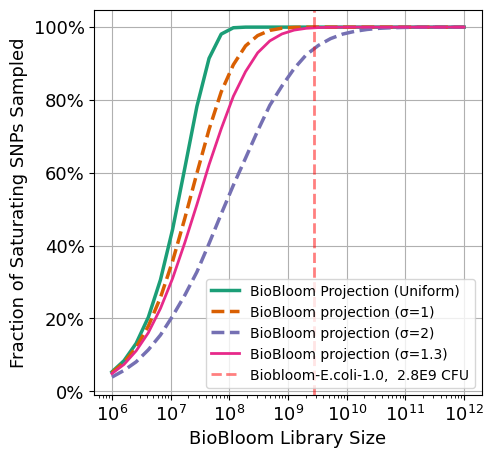

In [ ]:
### plotting the above separately, with improved formatting
#first plotting biobloom projections
#define consistent color set:
#import seaborn as sns
colors = sns.color_palette("Dark2", 6)

plt.figure(figsize=(5, 5))
# Top subplot: BioBloom projections
plt.plot(library_members, uniform,     label='BioBloom Projection (Uniform)', color=colors[0], linewidth=2.5) #marker='o'
plt.plot(library_members, mild_skew,   label='BioBloom projection (σ=1)', color=colors[1], linestyle='--', linewidth=2.5)
plt.plot(library_members, heavy_skew,  label='BioBloom projection (σ=2)', color=colors[2], linestyle='--', linewidth=2.5)
plt.plot(library_members, measured_skew,  label='BioBloom projection (σ=1.3)', color=colors[3], linewidth=2)
plt.axvline(2.8E9, color='red', linestyle='--', label='Biobloom-E.coli-1.0,  2.8E9 CFU', alpha=0.5, linewidth=2)
plt.legend()
#to place legend outside:
#plt.legend(
#    loc='center left',
#    bbox_to_anchor=(1.02, 0.8),   # push legend just right of the axes
#    borderaxespad=0.
#)

plt.xscale('log')
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}')) #y axis as percents
plt.ylabel('Fraction of Saturating SNPs Sampled', size=13)
plt.xlabel('BioBloom Library Size', size=13)
# Make tick labels larger
ax.tick_params(axis='both', which='major', labelsize=13)
#ax1.set_title('BioBloom Projection Models')
plt.grid(True)


plt.savefig(os.path.join(fig_dir, 'fig2', '2A_BB.png'), dpi=600, bbox_inches='tight')

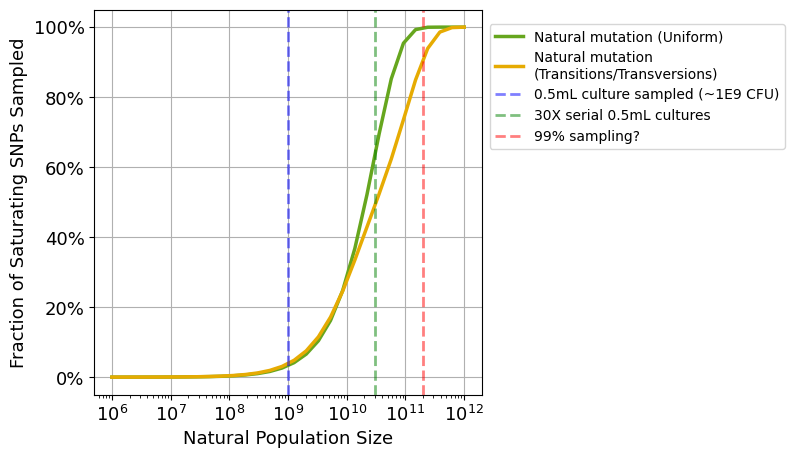

In [10]:
### next plotting predictions for natural mutation


plt.figure(figsize=(5, 5))

plt.plot(library_members, sampled_mutations, label='Natural mutation (Uniform)', color=colors[4], linewidth=2.5)
plt.plot(library_members, combined_fraction_sampled, label='Natural mutation \n(Transitions/Transversions)', color=colors[5], linewidth=2.5)

plt.axvline(1e9, color='blue', linestyle='--', label='0.5mL culture sampled (~1E9 CFU)', alpha=0.5, linewidth=2)
plt.axvline(1e9*30, color='green', linestyle='--', label='30X serial 0.5mL cultures', alpha=0.5, linewidth=2)
plt.axvline(2e11, color='red', linestyle='--', label='99% sampling?', alpha=0.5, linewidth=2)
plt.xscale('log')
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}')) #y axis as percents
plt.ylabel('Fraction of Saturating SNPs Sampled', size=13)
plt.xlabel('Natural Population Size', size=13)
# Make tick labels larger
ax.tick_params(axis='both', which='major', labelsize=13)
#ax1.set_title('BioBloom Projection Models')
plt.grid(True)
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.8),   # push legend just right of the axes
    borderaxespad=0.
)



#plt.savefig(os.path.join(fig_dir, '2B_natural_mutation.png'), dpi=600, bbox_inches='tight')


In [11]:
#simple calculation, what fraction of saturating mutations are sampled by 1E7 total mutations?

fraction_natural_pop_tube = coupon_collector(1E7, 1.5E7)
print(f"Fraction of saturating mutations sampled by 1E7 total mutations: {fraction_natural_pop_tube:.2%}")

#for text, predict 99% sammpling from natural population

Fraction of saturating mutations sampled by 1E7 total mutations: 48.66%


In [ ]:
#for text, predict 99% sammpling from natural population

library_members = 4.1E11  # number of CFU required to get 99% sampling
divisions = library_members # divisions can be approximated by total CFU


# Calculate number of mutations
transition_mutations = divisions * transition_rate * genome_size
transversion_mutations = divisions * transversion_rate * genome_size

transition_fraction_sampled = coupon_collector(transition_mutations, transition_sites)
transversion_fraction_sampled = coupon_collector(transversion_mutations, transversion_sites)


total_fraction_sampled = transition_fraction * transition_fraction_sampled + transversion_fraction * transversion_fraction_sampled



#what is the volume required to get 99% sampling? (mL)
cfu_per_ml_OD = 1E9
sat_OD = 5
volume_required = library_members / (cfu_per_ml_OD * sat_OD)
volume_required

82.0

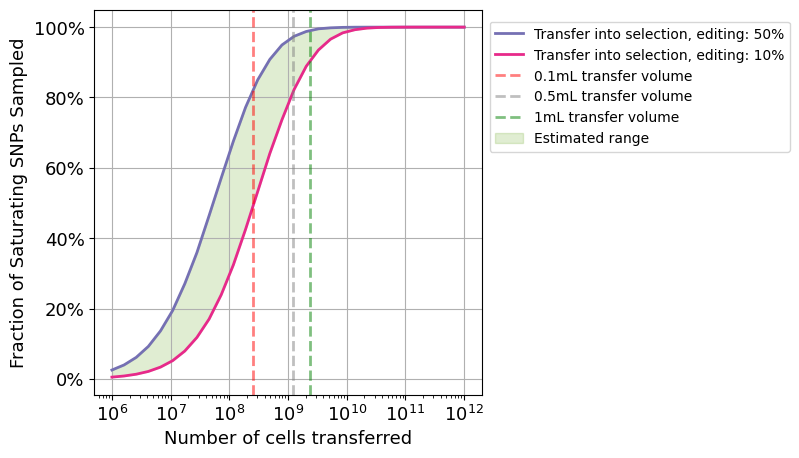

In [35]:
## also of interest is the "working volume" required
# when diluting the library for inductions or performing selection
#this takes into account an estimate of editing rate

genome_size = int(4.6e6) 
genome_sites = genome_size * 3 

pop_size = np.logspace(6, 12, 30, dtype=int)
biobloom_mutations = pop_size * 3/4
edit_rate = 0.5 #50% editing rate
edited_set = biobloom_mutations * edit_rate #"effective" number of mutations barcoded

#now, calculate the volume required to edit this many mutations
measured_skew_vol  = [expected_fraction_coverage_weighted_reps(int(n), genome_sites, sigma=1.3,  k_classes=1000, reps = 100) for n in edited_set]
#heavy_skew_vol = [expected_fraction_coverage_weighted_reps(int(n), genome_sites, sigma=2,  k_classes=1000, reps = 100) for n in edited_set]

#now, calculate the volume required to edit this many mutations, for a lower edit rate
edit_rate = 0.1 #10% editing rate
edited_set = biobloom_mutations * edit_rate 
measured_skew_vol_10  = [expected_fraction_coverage_weighted_reps(int(n), genome_sites, sigma=1.3,  k_classes=1000, reps = 100) for n in edited_set]

#ignoring edit rate, what volume?
#before_edit = biobloom_mutations 
#measured_skew_before_edit  = [expected_fraction_coverage_weighted_reps(int(n), genome_sites, sigma=1.3,  k_classes=1000, reps = 100) for n in before_edit]

# visualize this model
plt.figure(figsize=(5, 5))

#plt.plot(pop_size, heavy_skew_vol,  label='BioBloom projection (σ=2)', color=colors[2], linestyle='--', linewidth=2.5)
#plt.plot(pop_size, measured_skew_before_edit,  label='Transfer into editing', color='gray', linewidth=2, linestyle='--')
plt.plot(pop_size, measured_skew_vol,  label='Transfer into selection, editing: 50%', color=colors[2], linewidth=2)
plt.plot(pop_size, measured_skew_vol_10,  label='Transfer into selection, editing: 10%', color=colors[3], linewidth=2)
plt.axvline(0.25E9, color='red', linestyle='--', label='0.1mL transfer volume', alpha=0.5, linewidth=2)
plt.axvline(1.2E9, color='grey', linestyle='--', label='0.5mL transfer volume', alpha=0.5, linewidth=2)
plt.axvline(2.4E9, color='green', linestyle='--', label='1mL transfer volume', alpha=0.5, linewidth=2)

#annotate the range we likely expect 
plt.fill_between(
    pop_size,
    measured_skew_vol,
    measured_skew_vol_10,
    color=colors[4],
    alpha=0.2,
    label='Estimated range'
)


#plt.legend()
#to place legend outside:
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.8),   # push legend just right of the axes
    borderaxespad=0.
)

plt.xscale('log')
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}')) #y axis as percents
plt.ylabel('Fraction of Saturating SNPs Sampled', size=13)
plt.xlabel('Number of cells transferred', size=13)
#plt.title(f'Effect of transfer volume on Saturation Sampling')
# Make tick labels larger
ax.tick_params(axis='both', which='major', labelsize=13)
#ax1.set_title('BioBloom Projection Models')
plt.grid(True)



plt.savefig(os.path.join(fig_dir, 'supp_fig_transfer_volume.png'), dpi=600, bbox_inches='tight')
plt.show()

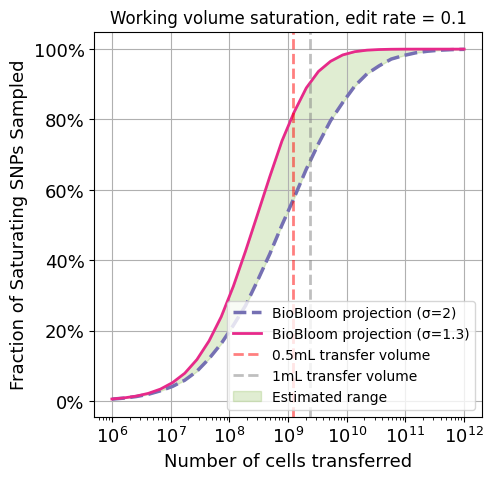

In [ ]:
#also testing with a lower edit rate

genome_size = int(4.6e6) 
genome_sites = genome_size * 3 

pop_size = np.logspace(6, 12, 30, dtype=int)
biobloom_mutations = pop_size * 3/4
edit_rate = 0.1 #10% editing rate
edited_set = biobloom_mutations * edit_rate #"effective" number of mutations barcoded

#now, calculate the volume required to edit this many mutations, for a lower edit rate
edit_rate = 0.1 #10% editing rate
edited_set = biobloom_mutations * edit_rate 
measured_skew_vol_10  = [expected_fraction_coverage_weighted_reps(int(n), genome_sites, sigma=1.3,  k_classes=1000, reps = 100) for n in edited_set]



# visualize this model
plt.figure(figsize=(5, 5))

plt.plot(pop_size, heavy_skew_vol,  label='BioBloom projection (σ=2)', color=colors[2], linestyle='--', linewidth=2.5)
plt.plot(pop_size, measured_skew_vol,  label='BioBloom projection (σ=1.3)', color=colors[3], linewidth=2)
plt.axvline(1.2E9, color='red', linestyle='--', label='0.5mL transfer volume', alpha=0.5, linewidth=2)
plt.axvline(2.4E9, color='grey', linestyle='--', label='1mL transfer volume', alpha=0.5, linewidth=2)

#annotate the range we likely expect 
plt.fill_between(
    pop_size,
    measured_skew_vol,
    heavy_skew_vol,
    color=colors[4],
    alpha=0.2,
    label='Estimated range'
)

plt.legend()
#to place legend outside:
#plt.legend(
#    loc='center left',
#    bbox_to_anchor=(1.02, 0.8),   # push legend just right of the axes
#    borderaxespad=0.
#)

plt.xscale('log')
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}')) #y axis as percents
plt.ylabel('Fraction of Saturating SNPs Sampled', size=13)
plt.xlabel('Number of cells transferred', size=13)
plt.title(f'Working volume saturation, edit rate = {edit_rate}')
# Make tick labels larger
ax.tick_params(axis='both', which='major', labelsize=13)
#ax1.set_title('BioBloom Projection Models')
plt.grid(True)
plt.show()


Below plots show other ways of visualizing the same data, and related modeling not shown in the published work.
These additional analyses are provided for interested readers, and many not be as complete or updated as modeling included in the published work.

Below these areas are additional blocks showing the skew estimation and visualization used in the figure 2 figures and shown in the supplement.

NameError: name 'library_members' is not defined

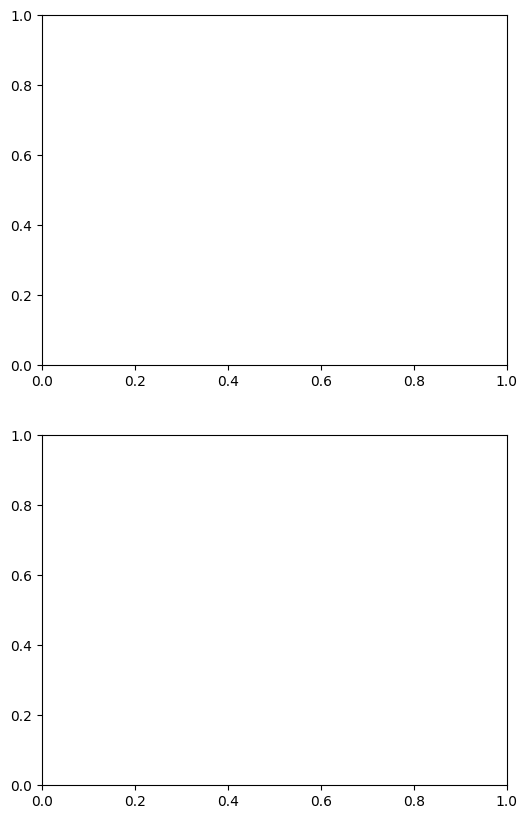

In [16]:
## version with two subplots
# Create figure with 2 subplots (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

#define consistent color set:
import seaborn as sns
colors = sns.color_palette("Dark2", 5)

# Top subplot: BioBloom projections
ax1.plot(library_members, uniform,     label='BioBloom Projection (Uniform)', color=colors[0]) #marker='o'
ax1.plot(library_members, mild_skew,   label='BioBloom projection (skew, σ=1)', color=colors[1])
ax1.plot(library_members, heavy_skew,  label='BioBloom projection (skew, σ=2)', color=colors[2])
ax1.axvline(2.8E9, color='red', linestyle='--', label='Biobloom-E.coli-1.0,  2.8E9 CFU obtained', alpha=0.5)

ax1.set_xscale('log')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
ax1.set_ylabel('Fraction of Mutation Space Sampled')
#ax1.set_title('BioBloom Projection Models')
ax1.grid(True)
ax1.legend()

# Bottom subplot: Natural mutation
ax2.plot(library_members, sampled_mutations, label='Natural mutation (Uniform)', color=colors[3]) #marker='o' optional
ax2.plot(library_members, combined_fraction_sampled, label='Natural mutation (spectra effect)', color=colors[4])
ax2.axvline(1e9, color='red', linestyle='--', label='Natural mutation, ~0.5mL (1E9 CFU)', alpha=0.5)
ax2.axvline(1e9*30, color='blue', linestyle='--', label='Natural mutation, \n30X transfers or small turbidostat', alpha=0.5)

ax2.set_xscale('log')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
ax2.set_xlabel('Population size')
ax2.set_ylabel('Fraction of Mutation Space Sampled')
#ax2.set_title('Natural Mutation Models')
ax2.grid(True)
ax2.legend(loc='upper left')

#plt.suptitle('Sampling Saturating SNP space', fontsize=16)
plt.tight_layout()

# Save to disk
#plt.savefig('mutation_sampling_comparison.pdf', dpi=600, bbox_inches='tight')
plt.show()


In [20]:
coupon_collector(1E7,1E7)

0.632120577028895

In [1]:
### predict mutations accumulated during fixation of adaptive alleles
# # given a simplified model of the time required for mutations to fix

# Parameters
N = 1e6  # population size
genome_size = 4.6e6  # E. coli genome size
s_vals = np.logspace(-2, 0, 100)  # selection coefficients from 1e-4 to 1

# Fixation time function
def fixation_time(s):
    return (2 / s) * np.log(2 * N)

# Mutation rates for conditions
conditions = {
    "WT (μ = 1e-10)": 1e-10,
    "Mutagenic (μ = 1e-8)": 1e-8
}

# Plot
plt.figure(figsize=(9, 6))

for label, mu in conditions.items():
    t_fix = fixation_time(s_vals)
    new_muts = t_fix * mu * genome_size
    plt.plot(s_vals, new_muts, label=label)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Selection coefficient (s) of mutation')
plt.ylabel('Expected new mutations during fixation')
plt.title('Mutations Accumulated During Fixation at Different Mutation Rates')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

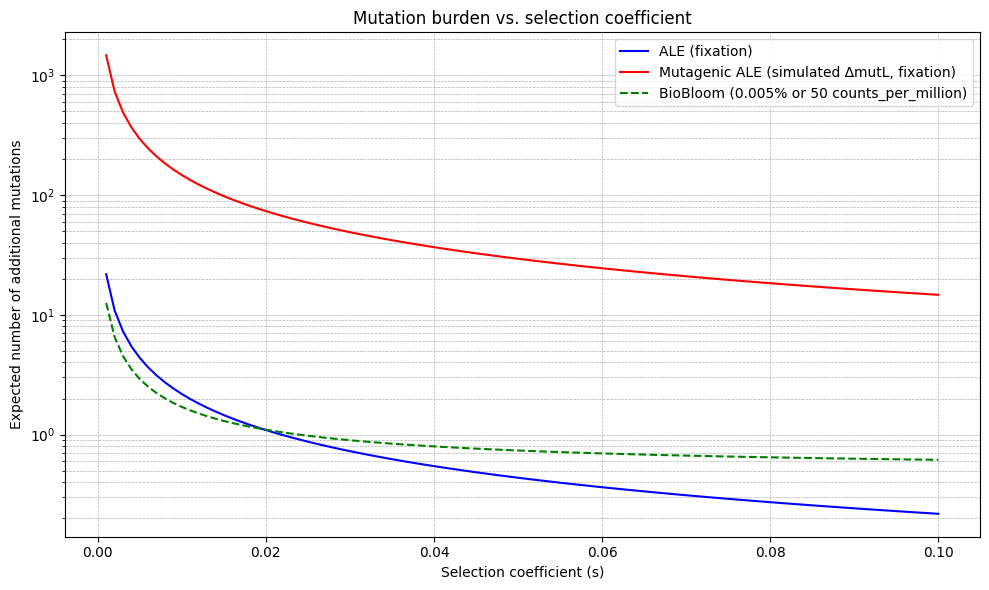

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 1e10  # effective population size
genome_size = 4.6e6  # E. coli genome size
#s_vals = np.logspace(-2, -1, 200)  # range of selection coefficients
s_vals = np.linspace(0.001, 0.1, 100)  # range of selection coefficients

# Mutation rates
mu_wt = 1e-10
mu_mutagenic = 6.73E-9

# 1. WT fixation: t_fix = (2/s) * ln(2N)
t_fix_wt = (2 / s_vals) * np.log(2 * N)
mut_burden_wt = t_fix_wt * mu_wt * genome_size

# 2. Mutagenic fixation
t_fix_mut = (2 / s_vals) * np.log(2 * N)
mut_burden_mut = t_fix_mut * mu_mutagenic * genome_size

# 3. BioBloom: to 0.1% frequency: t_f = (2/s) * ln(f/p0)
#biobloom requires 20 extra generations at mutL mutation rate
f_target = 0.00005
p0 = 1 / N
t_biobloom = (2 / s_vals) * np.log(f_target / p0) #time to fixation
t_biobloom_induction = 16 #time biobloom induced
mut_burden_partial_wt = t_biobloom * mu_wt * genome_size + t_biobloom_induction * mu_mutagenic * genome_size

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(s_vals, mut_burden_wt, label='ALE (fixation)', color='blue')
plt.plot(s_vals, mut_burden_mut, label='Mutagenic ALE (simulated ∆mutL, fixation)', color='red')
plt.plot(s_vals, mut_burden_partial_wt, label='BioBloom (0.005% or 50 counts_per_million)', color='green', linestyle='--')

#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Selection coefficient (s)')
plt.ylabel('Expected number of additional mutations')
plt.title('Mutation burden vs. selection coefficient')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

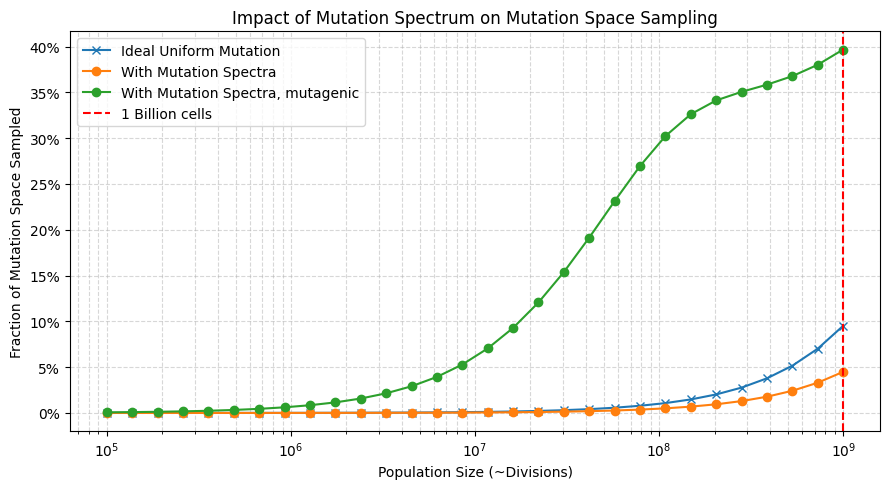

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Genome parameters
genome_size = int(4.6e6)
mutation_space = genome_size * 3  # total possible substitutions (e.g. 3 per base)

# Transition vs Transversion breakdown
transition_fraction = 1 / 3
transversion_fraction = 2 / 3
transition_sites = int(mutation_space * transition_fraction)
transversion_sites = int(mutation_space * transversion_fraction)

# Uniform model mutation rate (ideal case, all sites equal)
uniform_rate = 1e-10

# Mutation rates (realistic spectra)
transition_rate = 1e-10
transversion_rate = 2e-11

#mutation rate with simulated mutL allele, accounting for spectra
mutL_transition_rate = (1e-10)*200
mutL_transversion_rate = (2e-11)*5

# Range of cell divisions (i.e. genome replications)
divisions = np.logspace(5, 9, 30, dtype=int)

# Coupon collector model
def coupon_collector(n_mutations, n_targets):
    return 1 - ((1 - 1 / n_targets) ** n_mutations)

# Condition 1: Spectra-modeled
transition_mutations = divisions * transition_rate * transition_sites
transversion_mutations = divisions * transversion_rate * transversion_sites
transition_sampled = [coupon_collector(n, transition_sites) for n in transition_mutations]
transversion_sampled = [coupon_collector(n, transversion_sites) for n in transversion_mutations]
combined_spectra_sampled = [
    (transition_fraction * ts + transversion_fraction * tv)
    for ts, tv in zip(transition_sampled, transversion_sampled)
]

# Condition 2: Uniform mutation model (same rate at all sites)
uniform_mutations = divisions * uniform_rate * mutation_space
uniform_sampled = [coupon_collector(n, mutation_space) for n in uniform_mutations]

#mutation rate with simulated mutL allele, accounting for spectra
mutL_transition_rate = (1e-10)*200
mutL_transversion_rate = (2e-11)*5
#condition 3: mutL, spectra modeling
mutL_transition_mutations = divisions * mutL_transition_rate * transition_sites
mutL_transversion_mutations = divisions * mutL_transversion_rate * transversion_sites
mutL_transition_sampled = [coupon_collector(n, transition_sites) for n in mutL_transition_mutations]
mutL_transversion_sampled = [coupon_collector(n, transversion_sites) for n in mutL_transversion_mutations]
mutL_combined_spectra_sampled = [
    (transition_fraction * ts + transversion_fraction * tv)
    for ts, tv in zip(mutL_transition_sampled, mutL_transversion_sampled)
]

# Plotting
plt.figure(figsize=(9, 5))

# Idealized uniform model
plt.plot(divisions, uniform_sampled, label='Ideal Uniform Mutation', marker='x')
# Spectra-aware model
plt.plot(divisions, combined_spectra_sampled, label='With Mutation Spectra', marker='o')
#mutL model
plt.plot(divisions, mutL_combined_spectra_sampled, label='With Mutation Spectra, mutagenic', marker='o')

# Reference vertical line
plt.axvline(1e9, color='red', linestyle='--', label='1 Billion cells')

# Axes formatting
plt.xscale('log')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))  # percent format
plt.xlabel('Population Size (~Divisions)')
plt.ylabel('Fraction of Mutation Space Sampled')
plt.title('Impact of Mutation Spectrum on Mutation Space Sampling')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

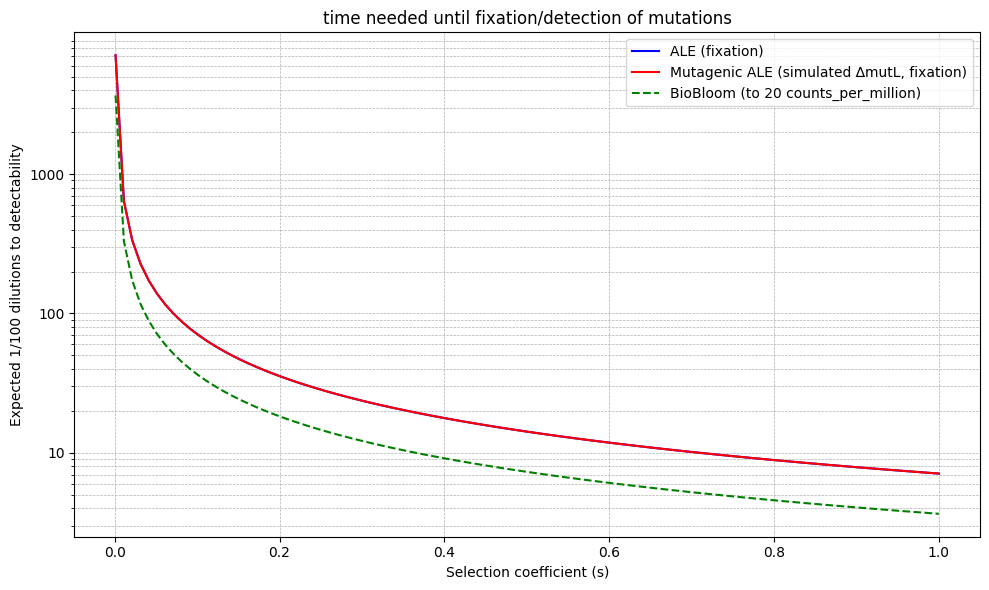

In [71]:
#ok but how much time does it take?

import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 1e10  # effective population size
genome_size = 4.6e6  # E. coli genome size
#s_vals = np.logspace(-2, -1, 200)  # range of selection coefficients
s_vals = np.linspace(0.001, 1, 100)  # range of selection coefficients



# 1. WT fixation: t_fix = (2/s) * ln(2N)
t_fix_wt = (2 / s_vals) * np.log(2 * N)

# 2. Mutagenic fixation
t_fix_mut = (2 / s_vals) * np.log(2 * N)

# 3. BioBloom: to 0.1% frequency: t_f = (2/s) * ln(f/p0)
#biobloom requires 20 extra generations at mutL mutation rate
f_CPM = 20
f_target = f_CPM/1E6 #count_per_M turned into frequency
p0 = 1 / N
t_biobloom = (2 / s_vals) * np.log(f_target / p0) #time to detectability
t_biobloom_induction = 16 #time biobloom induced

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(s_vals, t_fix_wt/6.67, label='ALE (fixation)', color='blue')
plt.plot(s_vals, t_fix_mut/6.67, label='Mutagenic ALE (simulated ∆mutL, fixation)', color='red')
plt.plot(s_vals, t_biobloom/6.67, label=f'BioBloom (to {f_CPM} counts_per_million)', color='green', linestyle='--')

#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Selection coefficient (s)')
plt.ylabel('Expected 1/100 dilutions to detectability')
plt.yticks([10, 100, 1000], ['10', '100', '1000'])
plt.title('time needed until fixation/detection of mutations')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

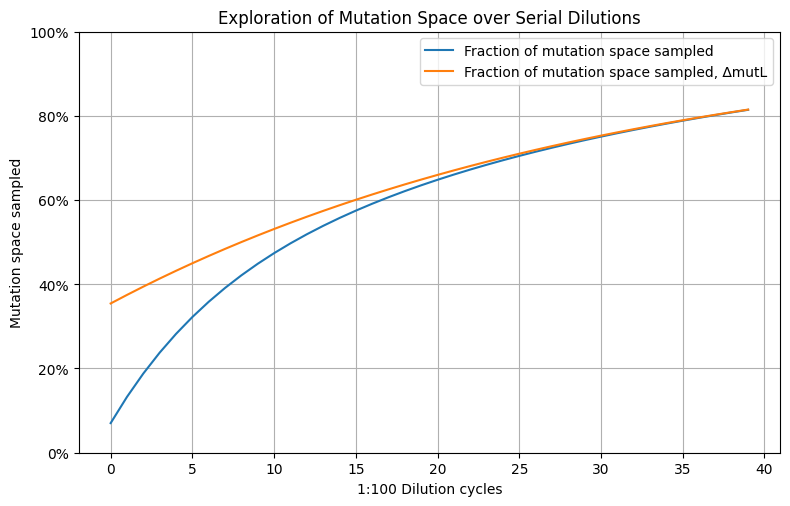

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Genome parameters
genome_size = int(4.6e6)
mutation_space = genome_size * 3
transition_fraction = 1 / 3
transversion_fraction = 2 / 3
transition_sites = int(mutation_space * transition_fraction)
transversion_sites = int(mutation_space * transversion_fraction)

# Mutation rates
mut_rate_transition = 1e-10
mut_rate_transversion = 2e-11
#mutagenic version
#mutation rate with simulated mutL allele, accounting for spectra
mutL_transition_rate = (1e-10)*200
mutL_transversion_rate = (2e-11)*5

# Dilution setup
volume_mL = 1
od = 2
cells_per_ml_od = 8e8
starting_divisions = volume_mL * od * cells_per_ml_od  # 1.6e9
dilution_factor = 100
dilutions = np.arange(0, 40)
num_divisions = starting_divisions + dilutions * starting_divisions  # total cumulative divisions

# Coupon collector function (vectorized)
def coupon_collector(n_mutations, n_targets):
    return 1 - np.power((1 - 1 / n_targets), n_mutations)

# Calculate sampled fractions
transition_fraction_sampled = coupon_collector(num_divisions * mut_rate_transition * transition_sites, transition_sites)
transversion_fraction_sampled = coupon_collector(num_divisions * mut_rate_transversion * transversion_sites, transversion_sites)
# Weighted average
combined_fraction_sampled = (
    transition_fraction * transition_fraction_sampled +
    transversion_fraction * transversion_fraction_sampled
)

#alernative condition: mutL, spectra modeling
mutL_transition_mutations = divisions * mutL_transition_rate * transition_sites
mutL_transversion_mutations = divisions * mutL_transversion_rate * transversion_sites
mutL_transition_fraction_sampled = coupon_collector(num_divisions * mutL_transition_rate * transition_sites, transition_sites)
mutL_transversion_fraction_sampled = coupon_collector(num_divisions * mutL_transversion_rate * transversion_sites, transversion_sites)
mutL_combined_fraction_sampled = (
    transition_fraction * mutL_transition_fraction_sampled +
    transversion_fraction * transversion_fraction_sampled
)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(dilutions, combined_fraction_sampled, label='Fraction of mutation space sampled')
plt.plot(dilutions, mutL_combined_fraction_sampled, label='Fraction of mutation space sampled, ∆mutL')
plt.ylabel("Mutation space sampled")
plt.xlabel("1:100 Dilution cycles")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.title("Exploration of Mutation Space over Serial Dilutions")
plt.show()

In [8]:
### for supplemental figure, determine skew estimate of biobloom library


## load depth from coverage alignment, and use this to estimate skew/sampling of bases
coverage_dir = os.path.join(data_dir, "t0_coverage")

coverage_df = pd.DataFrame()

samplenums = [1,2,3]

for samplenum in samplenums:
    i_coverage_path = os.path.join(coverage_dir, f"{samplenum}.coverage.txt")
    i_coverage_df = pd.read_csv(i_coverage_path, sep="\t", header=None)
    i_coverage_df.columns = [ "chrom", "pos", "depth"]
    i_coverage_df['samplenum'] = samplenum
    coverage_df = pd.concat([coverage_df, i_coverage_df])



coverage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13924956 entries, 0 to 4641651
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   chrom      object
 1   pos        int64 
 2   depth      int64 
 3   samplenum  int64 
dtypes: int64(3), object(1)
memory usage: 531.2+ MB


In [10]:
# Check for problematic values
print("Checking for problematic values:")
print(f"Total rows: {len(coverage_df)}")
print(f"NaN values in depth: {coverage_df['depth'].isna().sum()}")
print(f"Infinite values in depth: {np.isinf(coverage_df['depth']).sum()}")
print(f"Zero or negative values: {(coverage_df['depth'] <= 0).sum()}")

# Show problematic rows
problematic = coverage_df[(coverage_df['depth'].isna()) | 
                          (np.isinf(coverage_df['depth'])) | 
                          (coverage_df['depth'] <= 0)]
if len(problematic) > 0:
    print("\nProblematic rows:")
    print(problematic.head())

## zero values are problematic, so filter them out
#first, filter out zero values
coverage_df_nozero = coverage_df[coverage_df['depth']>0]

Checking for problematic values:
Total rows: 13924956
NaN values in depth: 0
Infinite values in depth: 0
Zero or negative values: 1846

Problematic rows:
           chrom     pos  depth  samplenum
0       U00096.3       1      0          1
1       U00096.3       2      0          1
157117  U00096.3  157118      0          1
157118  U00096.3  157119      0          1
157119  U00096.3  157120      0          1


In [11]:
# Estimate log-normal parameters for each replicate
def estimate_lognorm_sigma(df, value_col='depth', group_col='samplenum'):
    """
    Estimate the sigma (shape parameter) of a log-normal distribution
    for each group in the dataframe.
    """
    results = []
    
    for samplenum, group_df in df.groupby(group_col):
        # Log-transform the data
        log_depth = np.log(group_df[value_col])
        
        # Fit normal distribution to log-transformed data
        mu_hat, sigma_hat = stats.norm.fit(log_depth)
        
        results.append({
            'samplenum': samplenum,
            'sigma': sigma_hat,
            'mu': mu_hat,
            'mean_log': np.mean(log_depth),
            'std_log': np.std(log_depth)
        })
    
    return pd.DataFrame(results)

# Estimate parameters for each replicate
lognorm_params = estimate_lognorm_sigma(coverage_df_nozero, value_col='depth', group_col='samplenum')
print(lognorm_params)

   samplenum     sigma        mu  mean_log   std_log
0          1  1.300294  6.446036  6.446036  1.300294
1          2  1.267064  6.105233  6.105233  1.267064
2          3  1.284245  6.116131  6.116131  1.284245


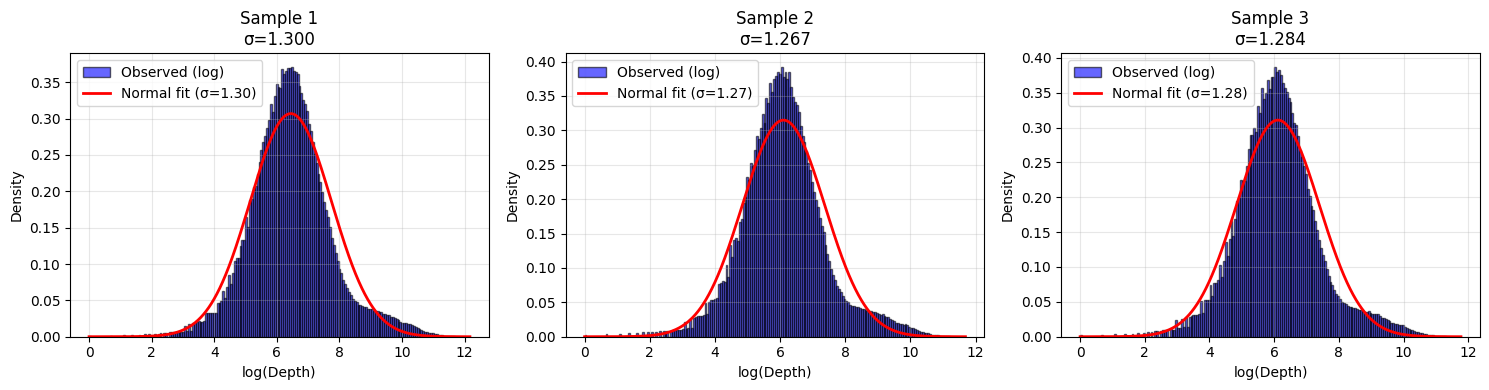

In [12]:
# Alternative: Plot on log-scale to better visualize log-normal distribution
def plot_lognormal_fits_logscale(coverage_df, lognorm_params, value_col='depth', group_col='samplenum', bins=100):
    """
    Plot histogram of true values (log-transformed) and overlay fitted normal distribution
    for each replicate. This helps visualize if the log-transform is actually normal.
    """
    num_samples = len(lognorm_params)
    
    # Determine grid size
    ncols = min(3, num_samples)
    nrows = int(np.ceil(num_samples / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten() if num_samples > 1 else [axes]
    
    for idx, (samplenum, group_df) in enumerate(coverage_df.groupby(group_col)):
        ax = axes[idx]
        
        # Get parameters for this replicate
        params = lognorm_params[lognorm_params['samplenum'] == samplenum].iloc[0]
        sigma = params['sigma']
        mu = params['mu']
        
        # Log-transform the observed data
        log_depth = np.log(group_df[value_col])
        
        # Plot histogram of log-transformed values
        ax.hist(log_depth, bins=bins, density=True, alpha=0.6, 
               label='Observed (log)', color='blue', edgecolor='black')
        
        # Generate model values for plotting (now using normal distribution!)
        x = np.linspace(log_depth.min(), log_depth.max(), 2000)
        y_model = stats.norm.pdf(x, loc=mu, scale=sigma)
        
        # Plot fitted normal distribution (not log-normal, since we're on log-scale)
        ax.plot(x, y_model, 'r-', linewidth=2, label=f'Normal fit (σ={sigma:.2f})')
        
        # Labels and title
        ax.set_xlabel('log(Depth)')
        ax.set_ylabel('Density')
        ax.set_title(f'Sample {samplenum}\nσ={sigma:.3f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(num_samples, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    return fig

# Create the log-scale plots
fig = plot_lognormal_fits_logscale(coverage_df_nozero, lognorm_params, bins=200)
plt.show()